### Differential abundance analyses

#### 1. Load required libraries

In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("apeglm")
# install.packages("pheatmap")
library(pheatmap, warn.conflicts = F, quietly = T)
library(ggplot2, warn.conflicts = F, quietly = T)
library(limma, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(edgeR, warn.conflicts = F, quietly = T)
library(Glimma, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)

Warning message:
“package ‘ggplot2’ was built under R version 4.1.3”

Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:


#### 2. Load data

In [2]:
# if you've already run deseq2 -- load environment
# load(".RData")

In [3]:
metadata <- read.table("map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
genecounts <- read.table("../02-STAR/homd_mapped_strict/featurecounts/read_counts.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")  

#### 3. Format for DESeq2 analysis

In [4]:
# only compare PD to PF
metadata <- metadata[metadata$tooth_type != "PE",]
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[order(colnames(genecounts)),]
# colnames(genecounts)
# rownames(metadata)
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PF"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 1177152 60 
metadata(1): version
assays(1): counts
rownames(1177152): SEQF1003_00001 SEQF1003_00002 ... SEQF3050_00510
  SEQF3050_02197
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(10): sample_id tooth_type ... ads_nmol_min_mg_of_protein
  concentration_ng_ul

#### 4. Run DESeq2

In [5]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm # this takes about an hour to complete
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function

norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 377862 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



    user   system  elapsed 
5772.872  233.976 4263.277 

In [6]:
# save.image()
res <- results(se_star, alpha=0.01)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(res$padj < 0.01, na.rm=TRUE))
summary(res)

[1] "number of genes with adjusted p value lower than 0.01:  314888"


out of 1166535 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)       : 90172, 7.7%
LFC < 0 (down)     : 224716, 19%
outliers [1]       : 0, 0%
low counts [2]     : 304491, 26%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [7]:
resultsNames(se_star)

[1] "Intercept"           "tooth_type_PF_vs_PD"

In [9]:
# filter out low count genes
resLFC <- lfcShrink(se_star, coef="tooth_type_PF_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(resLFC$padj < 0.01, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of genes with adjusted p value lower than 0.01:  309805"


out of 1166535 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 162259, 14%
LFC < 0 (down)     : 335883, 29%
outliers [1]       : 0, 0%
low counts [2]     : 214068, 18%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



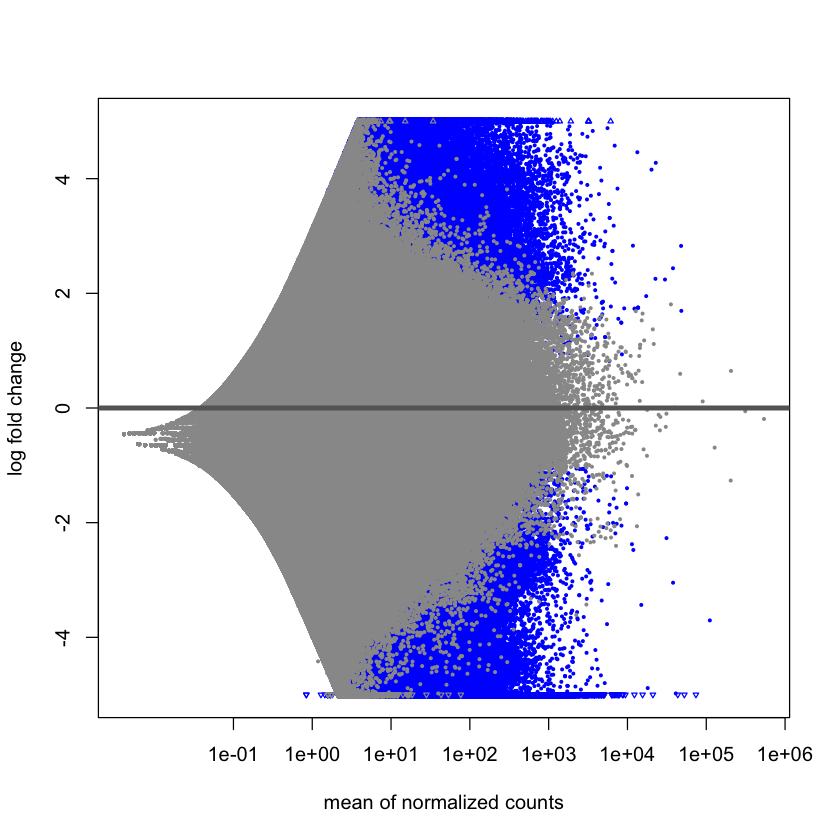

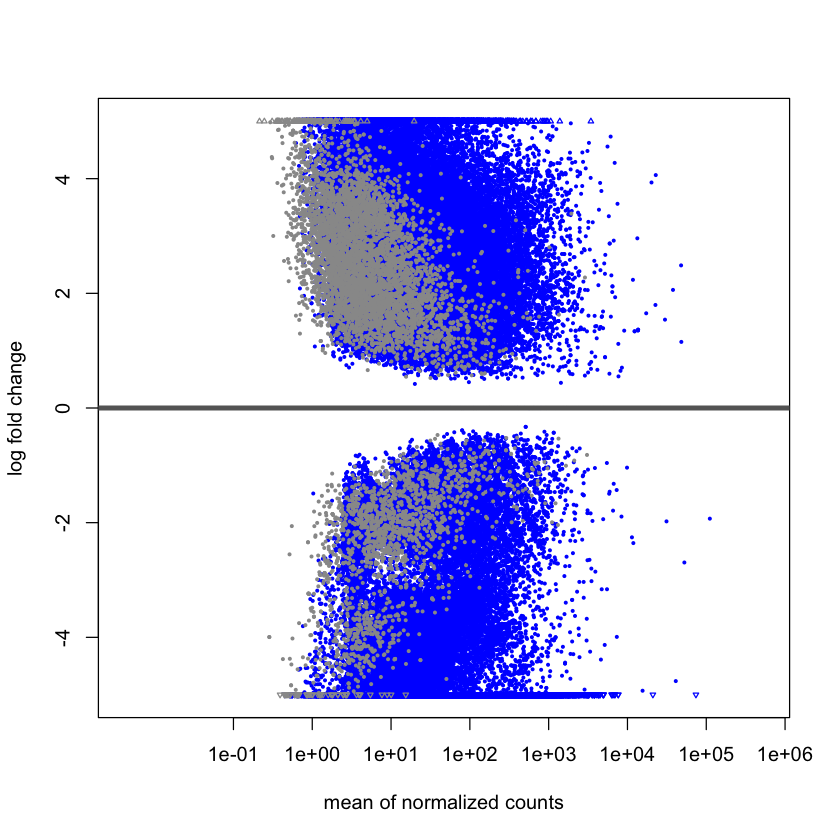

In [10]:
volcano_all <- plotMA(res, ylim=c(-5,5))
plotMA(res, ylim=c(-5,5))
volcano_flat <- plotMA(resLFC, ylim=c(-5,5))
plotMA(resLFC, ylim=c(-5,5))

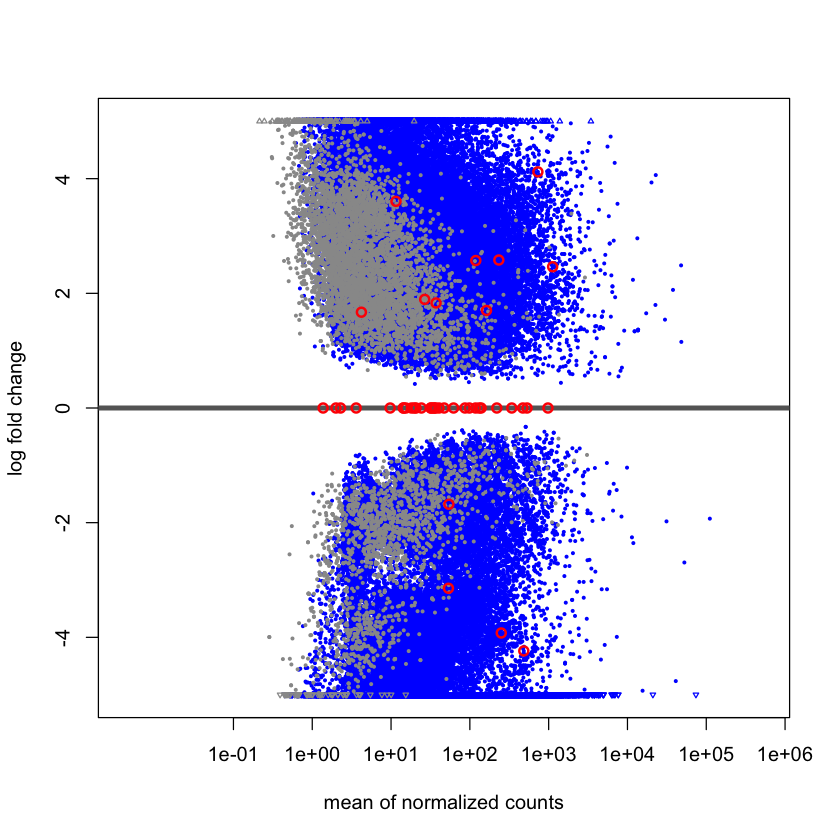

In [11]:
# test highlight some arcA genes
arcAids <- c("SEQF1018_00761","SEQF1480_00159","SEQF1480_00656","SEQF1576_01287","SEQF1600_01924","SEQF1610_00213","SEQF1654_01305","SEQF1655_01344","SEQF1693_00108","SEQF1693_02582","SEQF1701_02319","SEQF1702_01373","SEQF1766_00037","SEQF1783_00384","SEQF1847_01785","SEQF1849_00256","SEQF1849_01720","SEQF1853_01039","SEQF1854_01131","SEQF1885_01509","SEQF1933_01377","SEQF1964_00412","SEQF2007_01410","SEQF2010_01084","SEQF2016_01287","SEQF2031_01762","SEQF2222_00188","SEQF2349_01808","SEQF2391_00070","SEQF2397_00558","SEQF2444_01426","SEQF2479_01711","SEQF2573_02185","SEQF2585_01321","SEQF2587_00586","SEQF2605_00712","SEQF2609_01690","SEQF2625_00202","SEQF2705_03304","SEQF2745_02165","SEQF2748_01245","SEQF2750_02201","SEQF2751_01171","SEQF2852_00642","SEQF2976_00455")

plotMA(resLFC, ylim = c(-5,5)) 
with(subset(resLFC, rownames(resLFC) %in% arcAids), {
  points(baseMean, log2FoldChange, col = "red", cex = 1, lwd = 2)
#   text(baseMean, log2FoldChange, "SEQF1018_00761", pos = 2, col = "dodgerblue")
})

In [12]:
# transform for visualizations
vld <- vst(se_star)

pdf 
  2

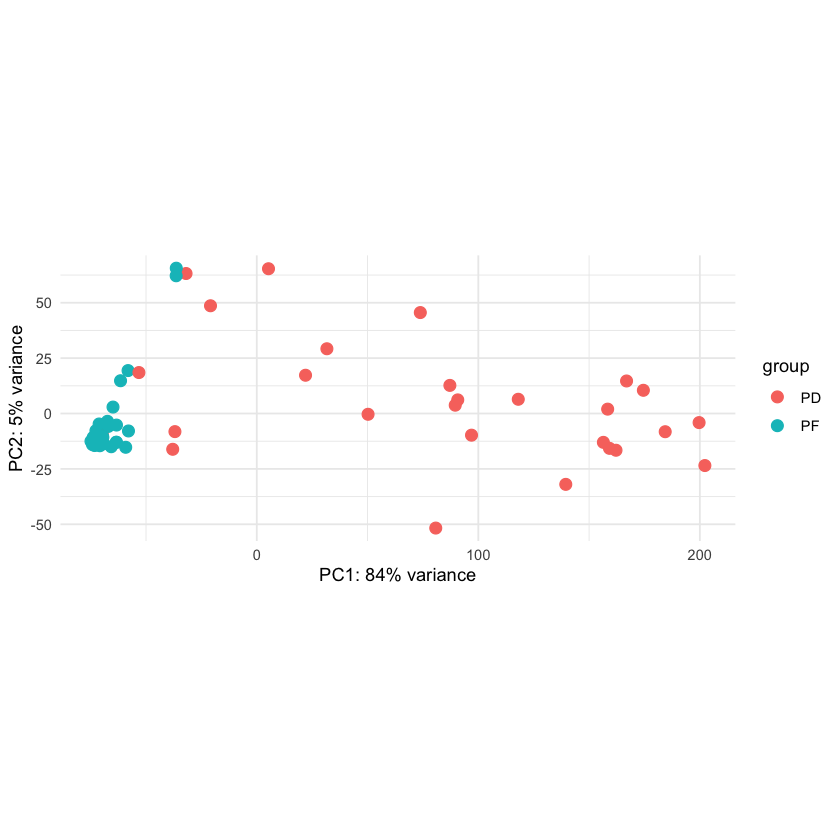

In [13]:
#Get 25 top varying genes
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 25)
 
#make a subset of the log transformed counts for just the top 25 varying genes
top25Counts <- assay(vld)[topVarGenes,]
write.csv(top25Counts, file="top25counts.vld.csv", quote=FALSE)
 
#PLOT PCA
#PCA using top 500 varying genes
pdf("pca_pdvpf.pdf")
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()

pdf 
  2

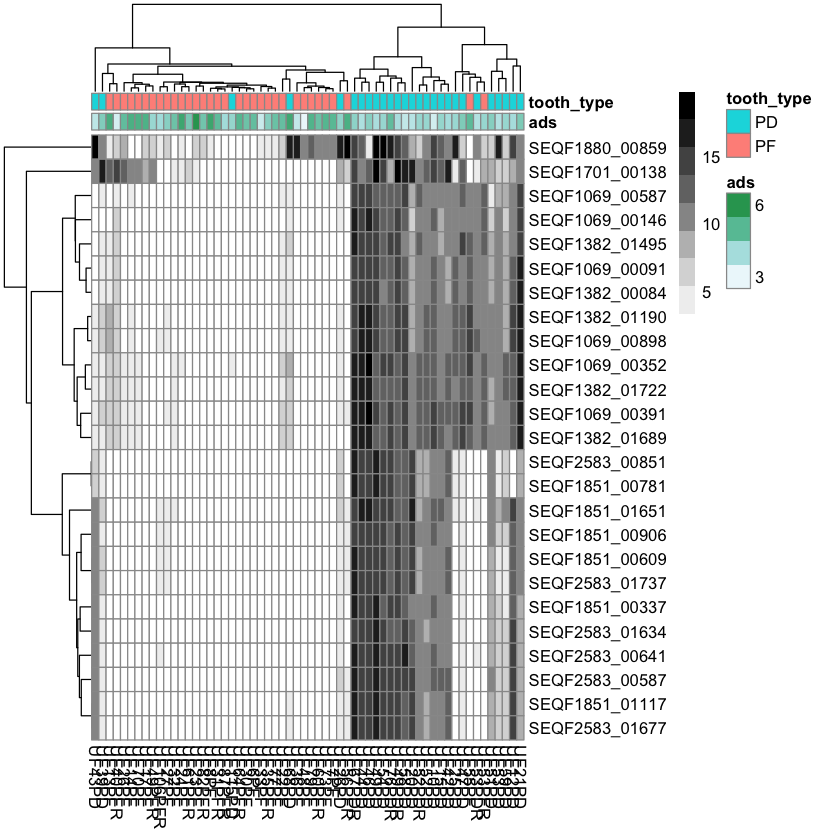

In [14]:
df <- as.data.frame(colData(vld)[,c("ads_nmol_min_mg_of_protein","tooth_type")])
df$ads_nmol_min_mg_of_protein <- log2(as.numeric(df$ads_nmol_min_mg_of_protein))
colnames(df) <- c("ads", "tooth_type")

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
library(RColorBrewer)
x <- pheatmap(top25Counts, annotation_col = df, color = brewer.pal(9, "Greys"))
save_pheatmap_pdf(x, "heatmap_pdvpf.pdf")